In [1]:
import collections
import matplotlib
import uproot
import sys
import site
import glob
import re
sys.path.insert(0, site.getusersitepackages())

import numpy             as np
import awkward           as ak
import matplotlib.pyplot as plt
import pandas            as pd

# Wider Cells
from IPython.display import display, HTML, Markdown
from tqdm.notebook   import tqdm
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
# Función para extraer el número después de "P"
def extract_p_number(filename):
    match = re.search(r"P(\d+)", filename)
    if match:
        return int(match.group(1))
    return -1  # Devuelve un valor pequeño si no se encuentra "P"

In [36]:
# run = 1354
run = 1440
files = glob.glob(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
#/eos/experiment/wcte/data/2025_commissioning/"+str(run)+"/*.root

# Ordenar los archivos usando extract_p_number
files = sorted(files, key=extract_p_number)
len(files)

64

# Window Filtering

First, we're just keeping the "parts" of the run (those files in which the run is split) that have at least 10k events (windows).

Second, we're selecting the windows that are separated less or equal than 20 times the nominal 524 288 ns separation.

In [37]:
uproot.open(files[0]).keys()[0]

'WCTEReadoutWindows;1'

In [38]:
tree = uproot.open(files[0])
keys = tree.keys()
print(keys)

branch = tree[keys[0]]
primal_event_numbers = [branch['event_number'].array().to_numpy()]
primal_window_times  = [branch['window_time'].array().to_numpy()]

for f in tqdm(files[1:]):
    tree2 = uproot.open(f)
    keys2 = tree2.keys()
    for key2 in keys2:
        branch2 = tree2[key2]
        events = branch2['event_number'].array().to_numpy()
        if len(events) != 0:
            primal_event_numbers.append(branch2['event_number'].array().to_numpy()+primal_event_numbers[-1].max()+1)
            primal_window_times.append(branch2['window_time'].array().to_numpy()+primal_window_times[-1].max()+1)   

['WCTEReadoutWindows;1']


  0%|          | 0/63 [00:00<?, ?it/s]

# See Unfiltered Data

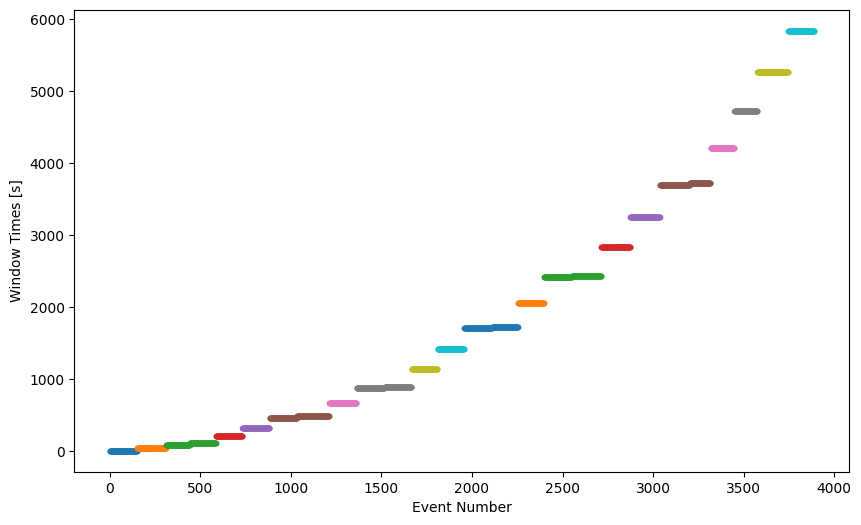

In [40]:

fig = plt.figure(figsize=(10,6))

parts = 20
for e,t in zip(primal_event_numbers[:parts], primal_window_times[:parts]):
    plt.scatter(e, t/1e9, marker='.')

plt.xlabel("Event Number")
plt.ylabel("Window Times [s]");
# plt.xlim(4000, 6000);
# plt.hlines(1920, 0, 600000);
# plt.text(0, 2000, "Run Duration [s]");

In [41]:
branch.keys()

['window_time',
 'start_counter',
 'run_id',
 'sub_run_id',
 'spill_counter',
 'event_number',
 'readout_number',
 'trigger_types',
 'trigger_times',
 'led_gains',
 'led_dacsettings',
 'led_ids',
 'led_card_ids',
 'led_slot_numbers',
 'led_event_types',
 'led_types',
 'led_sequence_numbers',
 'led_counters',
 'hit_mpmt_card_ids',
 'hit_pmt_channel_ids',
 'hit_mpmt_slot_ids',
 'hit_pmt_position_ids',
 'hit_pmt_charges',
 'hit_pmt_times',
 'pmt_waveform_mpmt_card_ids',
 'pmt_waveform_pmt_channel_ids',
 'pmt_waveform_mpmt_slot_ids',
 'pmt_waveform_pmt_position_ids',
 'pmt_waveform_times',
 'pmt_waveforms',
 'beamline_pmt_qdc_charges',
 'beamline_pmt_tdc_times',
 'beamline_pmt_qdc_ids',
 'beamline_pmt_tdc_ids']

# Event X (being X an event in which we have as many hits as waveforms): Assuming all the data is correct and no filtering is needed

In [ ]:
l = ["hit_mpmt_card_ids",
"hit_pmt_channel_ids",
"hit_mpmt_slot_ids",
"hit_pmt_position_ids",
"hit_pmt_charges",
"hit_pmt_times",
"pmt_waveform_mpmt_card_ids",
"pmt_waveform_pmt_channel_ids",
"pmt_waveform_mpmt_slot_ids",
"pmt_waveform_pmt_position_ids",
"pmt_waveform_times",
"pmt_waveforms"]

keys = ["hit_mpmt_card_ids", "pmt_waveforms"]

for ievt in range(20):
    ns = [len(branch[key].array()[ievt]) for key in keys]
    if (ns[0] != ns[1]): print('not equal!', ns)
    #for key in keys:
    #    print(ievt, ' > ', len(branch[key].array()[ievt]))

not equal! [746, 745]
not equal! [837, 847]
not equal! [856, 858]
not equal! [962, 916]
not equal! [860, 861]
not equal! [779, 804]
not equal! [769, 766]
not equal! [1626, 1624]
not equal! [854, 852]
not equal! [829, 828]
not equal! [916, 884]
not equal! [561, 560]
not equal! [814, 812]


In [ ]:
event = 8
print(len(branch["hit_mpmt_card_ids"].array()[event]))
print(len(branch[""]))
print(len(branch["pmt_waveforms"].array()[event]))

779
804


In [9]:
event = 8
hit_times = branch["hit_pmt_times"].array()[event]
hit_charges = branch["hit_pmt_charges"].array()[event]
hit_waveforms = branch["pmt_waveforms"].array()[event]


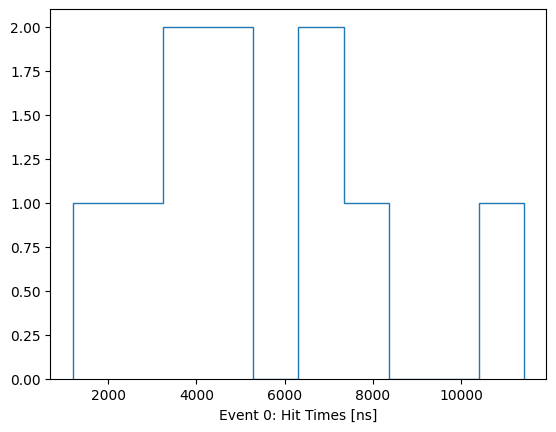

In [10]:
plt.hist(hit_times, histtype="step");
plt.xlabel("Event 0: Hit Times [ns]");

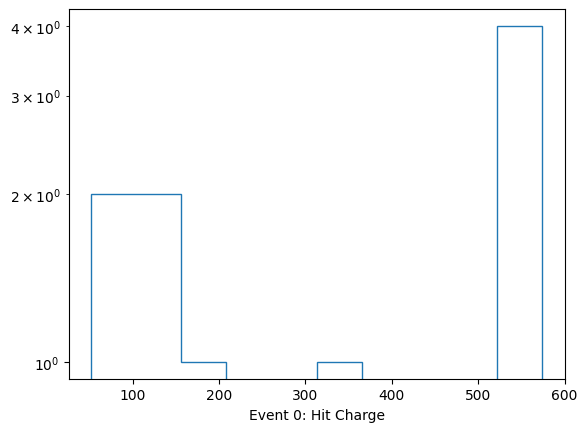

In [11]:
plt.hist(hit_charges, histtype="step");
plt.xlabel("Event 0: Hit Charge");
plt.yscale("log");

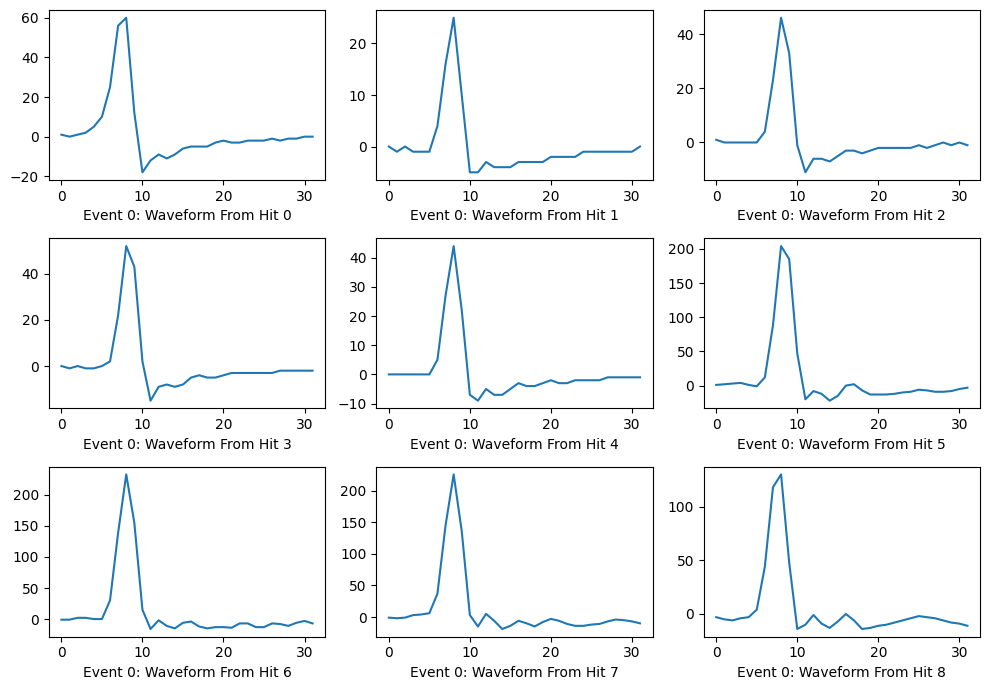

In [12]:
fig = plt.figure(figsize=(10, 7))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(hit_waveforms[i]);
    ax.set_xlabel(f"Event 0: Waveform From Hit {i}");

plt.tight_layout()

# Event X (being X an event in which we have as many hits as waveforms): Hits in the same mPMT and its channels

Card with the bigger number of hits is Card 130


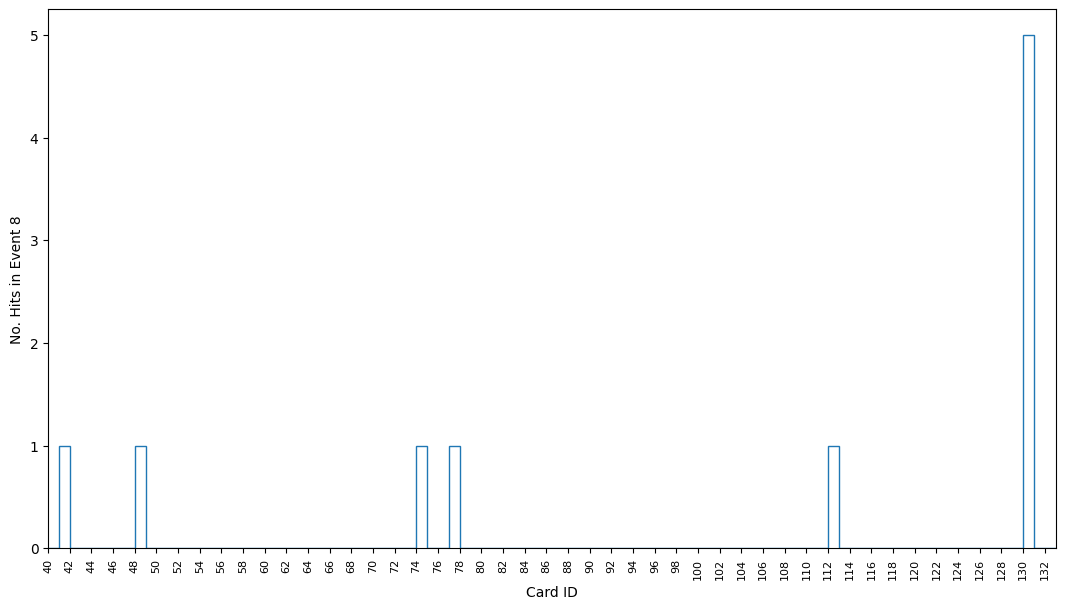

In [13]:
hit_card_ids = branch["hit_mpmt_card_ids"].array()[event]
fig = plt.figure(figsize=(13,7))
c, b, _ = plt.hist(hit_card_ids, bins=np.arange(0, 134, 1), histtype="step");
plt.xlabel("Card ID")
plt.ylabel(f"No. Hits in Event {event}")
plt.xticks(np.arange(0, 133, 2), rotation=90, fontsize=8)
plt.xlim(40, np.max(b))


print(f"Card with the bigger number of hits is Card {np.argmax(c)}")


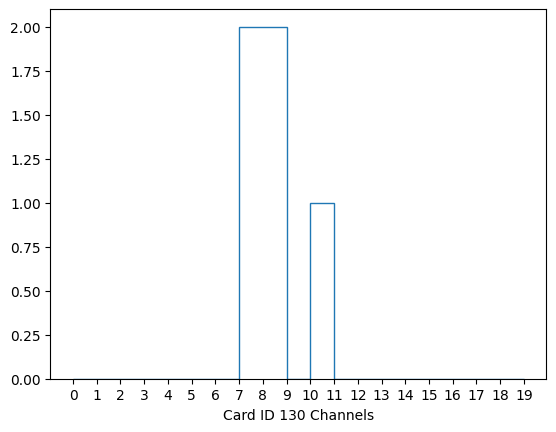

In [14]:
card_id_mask = (branch["hit_mpmt_card_ids"].array()[event] == np.argmax(c))
channels_hit_in_card_with_the_most_hits = branch["hit_pmt_channel_ids"].array()[event][card_id_mask]

a, b, _ = plt.hist(channels_hit_in_card_with_the_most_hits, bins=np.arange(0, 20, 1), histtype="step");
plt.xlabel(f"Card ID {np.argmax(c)} Channels");
plt.xticks(b);

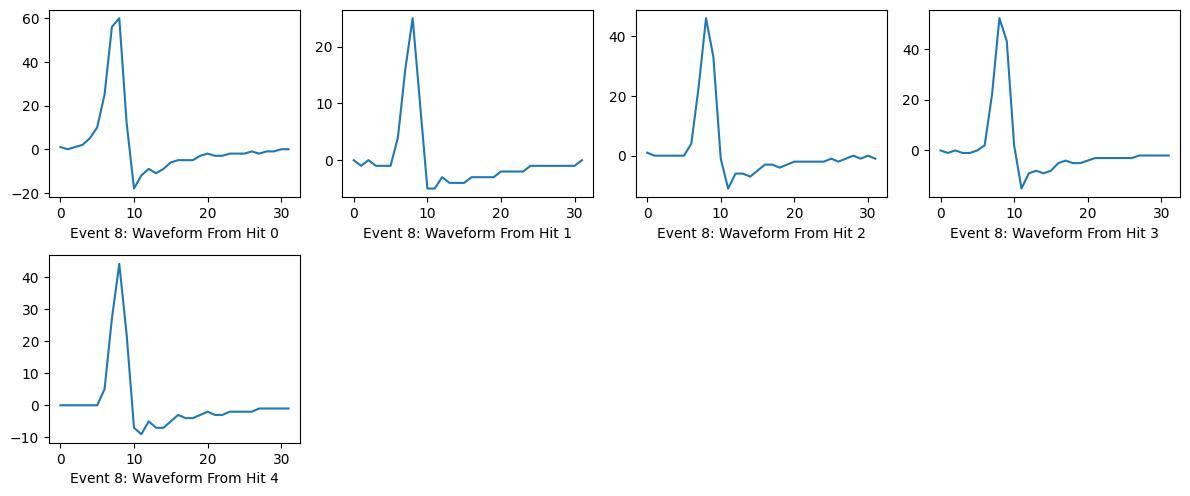

In [15]:
waveforms_from_hits_from_cardID_130 = hit_waveforms[card_id_mask]

fig = plt.figure(figsize=(12, 12))
for i in range(len(waveforms_from_hits_from_cardID_130)):
    ax = fig.add_subplot(5,4,i+1)
    ax.plot(hit_waveforms[i]);
    ax.set_xlabel(f"Event {event}: Waveform From Hit {i}");
    # ax.set_yscale("log");

plt.tight_layout()

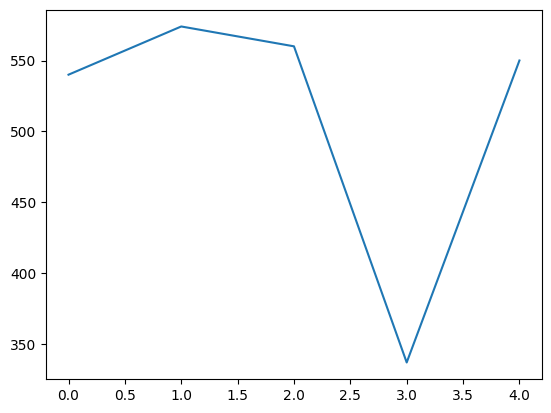

In [16]:
# plt.plot(hit_times[card_id_mask])
plt.plot(hit_charges[card_id_mask]);

# Info From ACT3-LR (Card 130 - Channels 7 and 8)

In [43]:
file_hit_card_ids = ak.flatten(branch["hit_mpmt_card_ids"].array())
file_hit_channels = ak.flatten(branch["hit_pmt_channel_ids"].array())
file_hit_charges  = ak.flatten(branch["hit_pmt_charges"].array())
file_hit_times    = ak.flatten(branch["hit_pmt_times"].array())

In [44]:
file_hit_card_ids_mask = (file_hit_card_ids == 130)
file_hit_channels_from_130 = file_hit_channels[file_hit_card_ids_mask]
file_hit_charges_from_130  = file_hit_charges[file_hit_card_ids_mask]
file_hit_times_from_130    = file_hit_times[file_hit_card_ids_mask]

Card with the bigger number of hits is Card 130


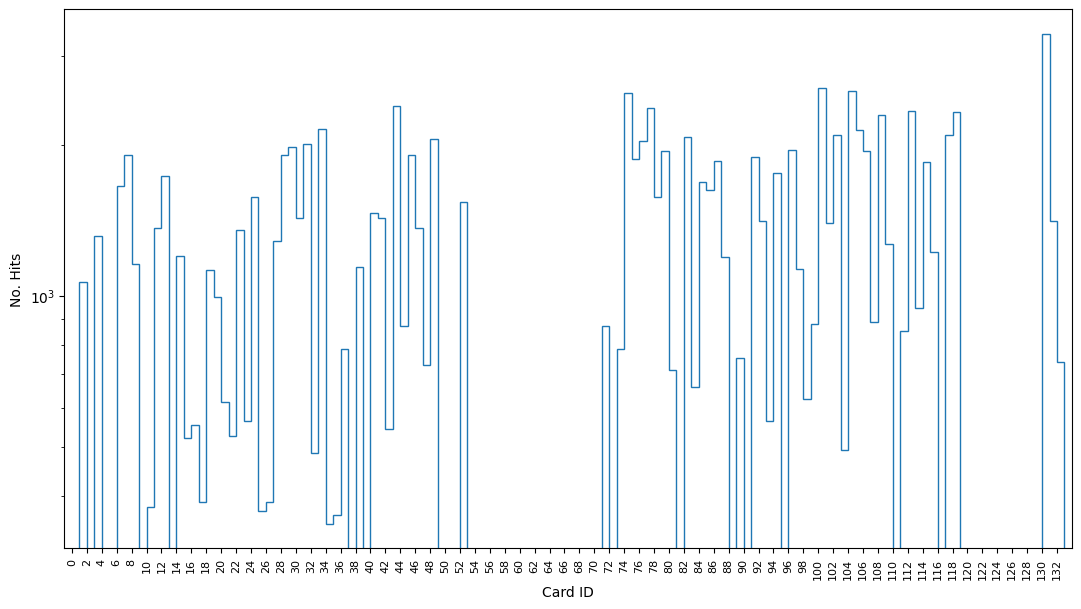

In [45]:
fig = plt.figure(figsize=(13,7))
c, b, _ = plt.hist(file_hit_card_ids, bins=np.arange(0, 134, 1), histtype="step");
plt.xlabel("Card ID")
plt.ylabel(f"No. Hits")
plt.xticks(np.arange(0, 133, 2), rotation=90, fontsize=8)
plt.xlim(-1, np.max(b)+1)
plt.yscale("log");


print(f"Card with the bigger number of hits is Card {np.argmax(c)}")


In [112]:
channels = ["ACT0-L", "ACT0-R", "ACT1-L", "ACT1-R", "NC", "ACT2-L", "ACT2-R", "ACT3-L", "ACT3-R", "ACT4-L", "ACT4-R", "ACT5-L", "ACT5-R",
            "T1-0L", "T1-0R", "T1-1L", "T1-1R", "HC-0", "HC-1", "Trigger"]

channels_dict = {0:"ACT0-L", 1:"ACT0-R", 2:"ACT1-L", 3:"ACT1-R", 4:"NC", 5:"ACT2-L", 6:"ACT2-R", 7:"ACT3-L", 8:"ACT3-R", 9:"ACT4-L", 
                 10:"ACT4-R", 11:"ACT5-L", 12:"ACT5-R", 13:"T1-0L", 14:"T1-0R", 15:"T1-1L", 16:"T1-1R", 17:"HC-0", 18:"HC-1", 19:"Trigger"}

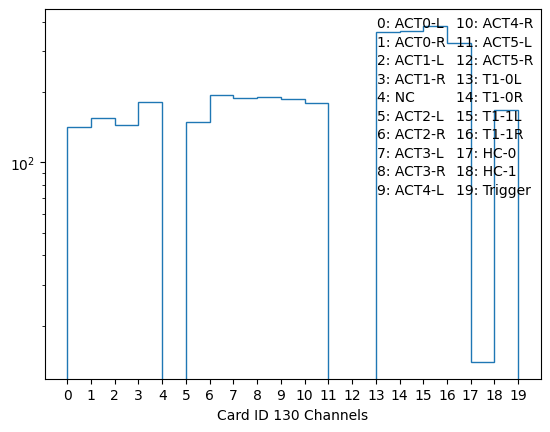

In [47]:
a, b, _ = plt.hist(file_hit_channels_from_130, bins=np.arange(0, 20, 1), histtype="step");
plt.xlabel(f"Card ID {np.argmax(c)} Channels");
plt.xticks(b);
plt.yscale("log")

y = 0.95
for i in range(int(len(b)/2)):
    plt.annotate(f"{int(b[i])}: {channels[i]}", [0.67,y], xycoords='axes fraction')
    y -= 0.05
y = 0.95
for i in range(int(len(b)/2), len(b)):
    plt.annotate(f"{int(b[i])}: {channels[i]}", [0.83,y], xycoords='axes fraction')
    y -= 0.05



# WaveForms

In [57]:
l = ["hit_mpmt_card_ids",
"hit_pmt_channel_ids",
"hit_mpmt_slot_ids",
"hit_pmt_position_ids",
"hit_pmt_charges",
"hit_pmt_times",
"pmt_waveform_mpmt_card_ids",
"pmt_waveform_pmt_channel_ids",
"pmt_waveform_mpmt_slot_ids",
"pmt_waveform_pmt_position_ids",
"pmt_waveform_times",
"pmt_waveforms"]

keys = ["hit_mpmt_card_ids", "pmt_waveforms"]

for ievt in range(20):
    ns = [len(branch[key].array()[ievt]) for key in keys]
    if (ns[0] != ns[1]): print('not equal!', ns)
    #for key in keys:
    #    print(ievt, ' > ', len(branch[key].array()[ievt]))

not equal! [746, 745]
not equal! [837, 847]
not equal! [856, 858]
not equal! [962, 916]
not equal! [860, 861]
not equal! [779, 804]
not equal! [769, 766]
not equal! [1626, 1624]
not equal! [854, 852]
not equal! [829, 828]
not equal! [916, 884]
not equal! [561, 560]
not equal! [814, 812]


In [91]:
file_waveform_card_ids  = ak.flatten(branch["pmt_waveform_mpmt_card_ids"].array())
file_waveforms          = ak.flatten(branch["pmt_waveforms"].array())
file_waveform_channel   = ak.flatten(branch["pmt_waveform_pmt_channel_ids"].array())
file_waveform_slot      = ak.flatten(branch["pmt_waveform_mpmt_slot_ids"].array())
file_waveform_positions = ak.flatten(branch["pmt_waveform_pmt_position_ids"].array())
file_waveform_times     = ak.flatten(branch["pmt_waveform_times"].array())

Card with the bigger number of hits is Card 130


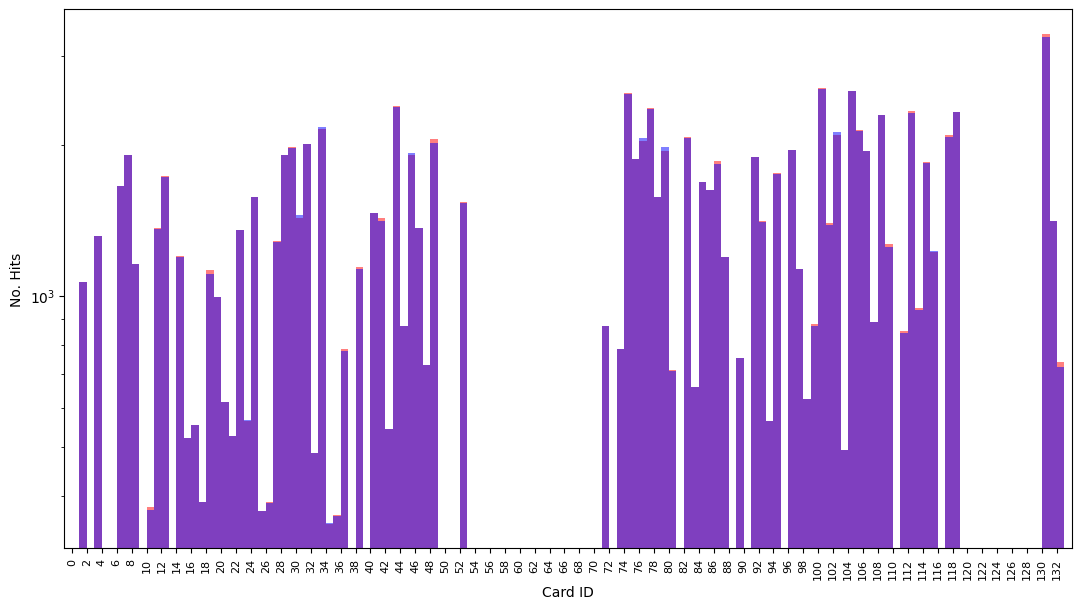

In [95]:
fig = plt.figure(figsize=(13,7))
c, b, _ = plt.hist(file_hit_card_ids, bins=np.arange(0, 134, 1), alpha=0.5, color="red");
plt.hist(file_waveform_card_ids, bins=np.arange(0, 134, 1), alpha=0.5, color="blue");
plt.xlabel("Card ID")
plt.ylabel(f"No. Hits")
plt.xticks(np.arange(0, 133, 2), rotation=90, fontsize=8)
plt.xlim(-1, np.max(b)+1)
plt.yscale("log");


print(f"Card with the bigger number of hits is Card {np.argmax(c)}")

In [ ]:
nevents = 1
event_waveform_card_ids  = branch["pmt_waveform_mpmt_card_ids"].array()[nevents]
event_waveforms          = branch["pmt_waveforms"].array()[nevents]
event_waveform_channel   = branch["pmt_waveform_pmt_channel_ids"].array()[nevents]
event_waveform_slot      = branch["pmt_waveform_mpmt_slot_ids"].array()[nevents]
event_waveform_positions = branch["pmt_waveform_pmt_position_ids"].array()[nevents]
event_waveform_times     = branch["pmt_waveform_times"].array()[nevents]

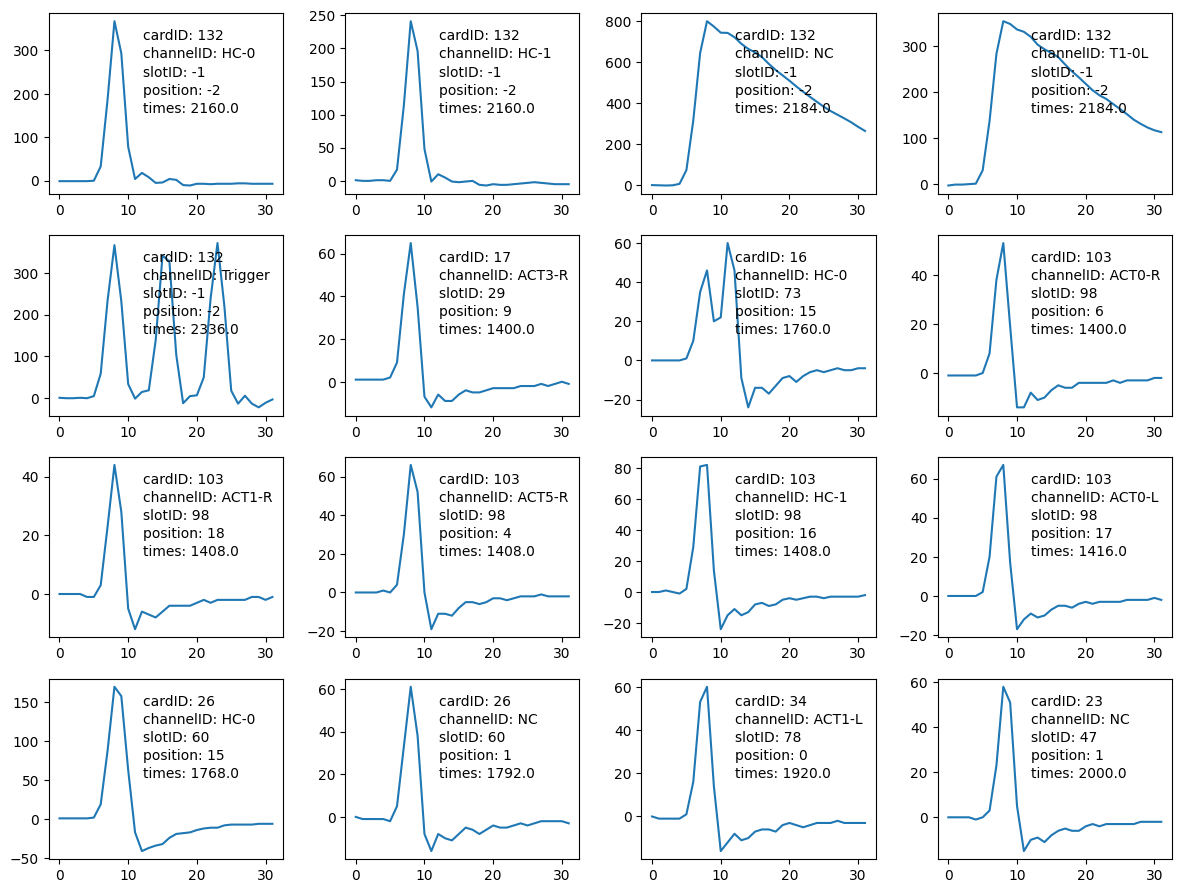

In [115]:
x = 0.40
fig = plt.figure(figsize=(12,9))
for numHit in range(16):
    ax = fig.add_subplot(4,4,numHit+1)
    ax.plot(event_waveforms[numHit])
    ax.annotate(f"cardID: {event_waveform_card_ids[numHit]}", [x,0.85], xycoords='axes fraction')
    ax.annotate(f"channelID: {channels_dict[event_waveform_channel[numHit]]}", [x,0.75], xycoords='axes fraction')
    ax.annotate(f"slotID: {event_waveform_slot[numHit]}", [x,0.65], xycoords='axes fraction')
    ax.annotate(f"position: {event_waveform_positions[numHit]}", [x,0.55], xycoords='axes fraction')
    ax.annotate(f"times: {event_waveform_times[numHit]}", [x,0.45], xycoords='axes fraction');

plt.tight_layout()

In [127]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import math

x = 0.40
plots_per_page = 16
total_hits = len(event_waveforms)

# Crear el PDF
with PdfPages("event_waveforms.pdf") as pdf:
    for page_start in tqdm(range(0, total_hits, plots_per_page), total=round(total_hits/plots_per_page)):
        fig = plt.figure(figsize=(12, 9))
        for i in range(plots_per_page):
            numHit = page_start + i
            if numHit >= total_hits:
                break
            ax = fig.add_subplot(4, 4, i + 1)
            ax.plot(event_waveforms[numHit])
            ax.annotate(f"numHit: {numHit}", [x, 0.85], xycoords='axes fraction')
            ax.annotate(f"cardID: {event_waveform_card_ids[numHit]}", [x, 0.75], xycoords='axes fraction')
            ax.annotate(f"channelID: {channels_dict[event_waveform_channel[numHit]]}", [x, 0.65], xycoords='axes fraction')
            ax.annotate(f"slotID: {event_waveform_slot[numHit]}", [x, 0.55], xycoords='axes fraction')
            ax.annotate(f"position: {event_waveform_positions[numHit]}", [x, 0.45], xycoords='axes fraction')
            ax.annotate(f"times: {event_waveform_times[numHit]}", [x, 0.35], xycoords='axes fraction')

        plt.tight_layout()
        pdf.savefig(fig)  # Guardar la figura en el PDF
        plt.close(fig)    # Cerrar para liberar memoria


  0%|          | 0/39 [00:00<?, ?it/s]